# Import library

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import glob, os
import numpy as np
import cv2
from matplotlib import animation
import math
import warnings
import matplotlib.cm as cm

# User defined parameters

In [2]:
cutoff_p = 0.95
project_name = r'\brain_intan_031522-Hao_Shen-2022-03-18\vid3'
pixels_per_m = 800
moving_average_w = 5
cutoff_v = 0.03
rat_type = 'Soft Brain'
sec_to_compare = 5 * 60

# Read in data

In [3]:
csv_path = r"C:\Users\haosh\Documents\Lab\Behavior\DeepLabCut" + project_name+ r"\videos"
os.chdir(csv_path)
df = pd.read_csv(glob.glob("*filtered.csv")[0], header=None)
df

,0,1,2,3,4,5,6,7,8,9
0,scorer,DLC_resnet50_0315_brain_intanMar16shuffle1_200000,DLC_resnet50_0315_brain_intanMar16shuffle1_200000,DLC_resnet50_0315_brain_intanMar16shuffle1_200000,DLC_resnet50_0315_brain_intanMar16shuffle1_200000,DLC_resnet50_0315_brain_intanMar16shuffle1_200000,DLC_resnet50_0315_brain_intanMar16shuffle1_200000,DLC_resnet50_0315_brain_intanMar16shuffle1_200000,DLC_resnet50_0315_brain_intanMar16shuffle1_200000,DLC_resnet50_0315_brain_intanMar16shuffle1_200000
1,bodyparts,snout,snout,snout,body_center,body_center,body_center,tail_base,tail_base,tail_base
2,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood
3,0,827.3828735351562,186.91607666015625,0.9994422793388367,913.8128662109375,192.47821044921875,0.9999836683273315,980.433349609375,184.93572998046875,0.9999910593032837
4,1,827.51953125,187.0382537841797,0.9994865655899048,913.9859008789062,192.54434204101562,0.9999825954437256,980.4814453125,184.93572998046875,0.9999902248382568
...,...,...,...,...,...,...,...,...,...,...
12989,12986,798.4210205078125,435.24627685546875,0.8228986263275146,856.643310546875,407.2066345214844,0.9998836517333984,902.69287109375,362.544921875,0.9999425411224365
12990,12987,776.8857421875,374.02655029296875,0.8144568800926208,856.643310546875,407.1869201660156,0.999881386756897,902.69287109375,362.5684814453125,0.9999407529830933
12991,12988,776.8857421875,374.02655029296875,0.7475273013114929,856.6139526367188,407.1869201660156,0.9998917579650879,902.6744384765625,362.57000732421875,0.9999432563781738
12992,12989,776.5257568359375,373.92694091796875,0.7465152740478516,856.6139526367188,407.0419616699219,0.9998893737792969,902.654296875,362.57000732421875,0.9999485015869141


# Replace coordinates with p less than cutoff_p to be np.nan

In [4]:
body_parts = df.iloc[1].unique()[1:]

length = df.shape[0] - 3
body_part_arr = np.empty((length, 1))


for body_part in body_parts:
    body_part_df = df[df.columns[df.iloc[1] == body_part]]
    body_part_temp = body_part_df.iloc[3:, 0:3]
    body_part_temp_x = np.array(body_part_temp.apply(lambda x:np.nan if float(x.values[2]) < cutoff_p \
                                                     else float(x.values[0]), axis=1)).reshape(-1,1)

    body_part_temp_y = np.array(body_part_temp.apply(lambda x:np.nan if float(x.values[2]) < cutoff_p \
                                                     else float(x.values[1]), axis=1)).reshape(-1,1)
    body_part_arr = np.hstack((body_part_arr, body_part_temp_x, body_part_temp_y))

body_part_arr = body_part_arr[:, 1:]
pd.DataFrame(body_part_arr)

,0,1,2,3,4,5
0,827.382874,186.916077,913.812866,192.478210,980.433350,184.935730
1,827.519531,187.038254,913.985901,192.544342,980.481445,184.935730
2,827.583679,187.089478,914.101807,192.605820,980.527710,184.935730
3,827.519531,187.089478,914.101807,192.605820,980.527710,184.935730
4,827.519531,187.089478,914.163208,192.623840,980.527710,184.935730
...,...,...,...,...,...,...
12986,NaN,NaN,856.643311,407.206635,902.692871,362.544922
12987,NaN,NaN,856.643311,407.186920,902.692871,362.568481
12988,NaN,NaN,856.613953,407.186920,902.674438,362.570007
12989,NaN,NaN,856.613953,407.041962,902.654297,362.570007


In [5]:
print(f'Counts of np.nan is {np.sum(np.isnan(body_part_arr))}')

Counts of np.nan is 4856


# Interpolate np.nan with previous values

In [6]:
# for c in range(body_part_arr.shape[1]):
#     flag = False
#     for r in range(body_part_arr.shape[0]):
#         if not flag:
#             if np.isnan(body_part_arr[r][c]):
#                 continue
#             else:
#                 flag = True
#         else:
#             if np.isnan(body_part_arr[r][c]):
#                 body_part_arr[r][c] = body_part_arr[r-1][c]
#             else:
#                 continue

# Interpolate the np.nan smoothly based on start and end coordinate

In [7]:
for c in range(body_part_arr.shape[1]):
    # Fill in nan in the front
    if np.isnan(body_part_arr[0, c]):
        for r in range(1, body_part_arr.shape[0]):
            if np.isnan(body_part_arr[r, c]):
                continue
            else:
                body_part_arr[:r, c] = body_part_arr[r, c]
                break
    
    # Fill in nan at the back
    if np.isnan(body_part_arr[-1, c]):
        for r in range(body_part_arr.shape[0]-2, -1, -1):
            if np.isnan(body_part_arr[r, c]):
                continue
            else:
                body_part_arr[r+1:, c] = body_part_arr[r, c]
                break
    
    # Fill in nan in the center
    null_bool = np.isnan(body_part_arr[:, c]) * 1
    indicater_vec = null_bool[:-1] - null_bool[1:]
    neg_idx_start = []
    pos_idx_stop = []
    for i in range(len(indicater_vec)):
        if indicater_vec[i] == -1:
            neg_idx_start.append(i + 1)
        elif indicater_vec[i] == 1:
            pos_idx_stop.append(i + 1)
            
    assert(len(neg_idx_start) == len(pos_idx_stop))
    for i in range(len(neg_idx_start)):
        assert(neg_idx_start[i] < pos_idx_stop[i])
        start_val = body_part_arr[neg_idx_start[i] - 1, c]
        end_val = body_part_arr[pos_idx_stop[i], c]
        part = (end_val - start_val) / (pos_idx_stop[i] - neg_idx_start[i] + 1)
        idx = neg_idx_start[i]
        while idx < pos_idx_stop[i]:
            body_part_arr[idx, c] = start_val + part
            start_val += part
            idx += 1
            
body_part_arr

array([[827.38287354, 186.91607666, 913.81286621, 192.47821045,
        980.43334961, 184.93572998],
       [827.51953125, 187.03825378, 913.98590088, 192.54434204,
        980.48144531, 184.93572998],
       [827.5836792 , 187.08947754, 914.10180664, 192.6058197 ,
        980.52770996, 184.93572998],
       ...,
       [772.24481201, 379.72607422, 856.61395264, 407.18692017,
        902.67443848, 362.57000732],
       [772.24481201, 379.72607422, 856.61395264, 407.04196167,
        902.65429688, 362.57000732],
       [772.24481201, 379.72607422, 856.56622314, 407.03106689,
        902.55102539, 362.56848145]])

In [8]:
print(f'Counts of np.nan is {np.sum(np.isnan(body_part_arr))}')

Counts of np.nan is 0


# Plot trajectory

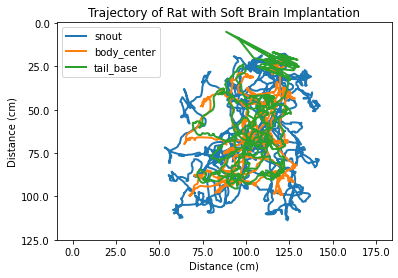

12991

In [9]:
if glob.glob("*.avi")[0] == 'tracker.avi':
    vid = glob.glob("*.avi")[1]
else:
    vid = glob.glob("*.avi")[0]

cap = cv2.VideoCapture(vid)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if frame_count/fps < sec_to_compare:
    sec_to_compare = frame_count/fps
    

%matplotlib inline
fig, ax = plt.subplots()
ax.axis('equal')
for i, body_part in enumerate(body_parts):
    x_i = i*2
    y_i = x_i + 1
    plt.plot(body_part_arr[:round(sec_to_compare * fps), x_i], body_part_arr[:round(sec_to_compare * fps), y_i], lw=2, label=body_part)
    
# plt.vlines(x=200, ymin=200, ymax=1400, colors='k', ls=':', lw=2)
# plt.vlines(x=1400, ymin=200, ymax=1400, colors='k', ls=':', lw=2) 
# plt.hlines(y=200, xmin=200, xmax=1400, colors='k', ls=':', lw=2)
# plt.hlines(y=1400, xmin=200, xmax=1400, colors='k', ls=':', lw=2, label='approximate_field')

# plt.xlim([0, 1648])
# plt.ylim([0, 1648])

plt.xticks(np.arange(0, width, 200), np.round(np.arange(0, width, 200)/pixels_per_m*100,1))
plt.yticks(np.arange(0, height, 200), np.round(np.arange(0, height, 200)/pixels_per_m*100,1))

plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')
plt.title('Trajectory of Rat with '+ rat_type +' Implantation')
ax.invert_yaxis()
plt.legend()
plt.show()

frame_count

# Plot Speed

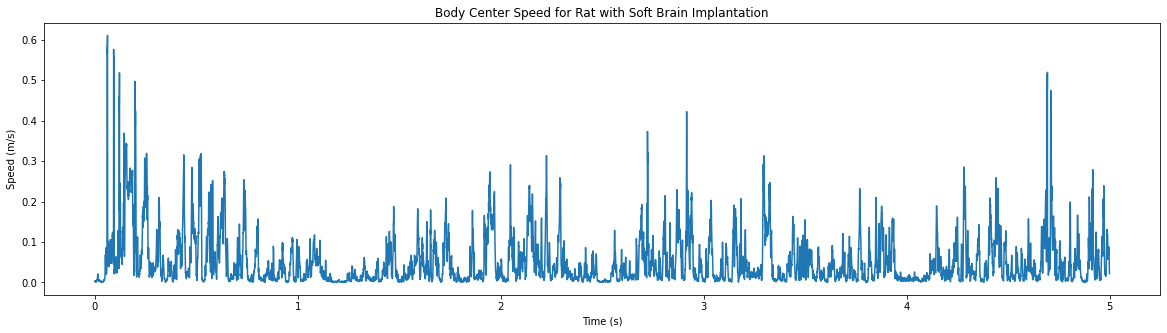

In [10]:
total_distance = [0]
speed = [0]

for i in range(1, body_part_arr.shape[0]):
    addition_distance = (math.sqrt((body_part_arr[i, 2] - body_part_arr[i-1, 2])**2 + (body_part_arr[i, 3] - body_part_arr[i-1, 3])**2))/pixels_per_m
    total_distance.append(total_distance[-1] + addition_distance)
    
#     if i % 10 != 0:
#         speed.append(speed[-1])
#     else:
#         addition_distance = (math.sqrt((body_part_arr[i, 2] - body_part_arr[i-2, 2])**2 + (body_part_arr[i, 3] - body_part_arr[i-2, 3])**2))/pixels_per_m
#         speed.append(addition_distance / (1/fps * 2))
    speed.append(addition_distance / (1/fps))

speed_filtered = np.convolve(speed, np.ones(moving_average_w), 'same') / moving_average_w

# # plt.plot(np.arange(body_part_arr.shape[0])/fps/60, total_distance)
plt.subplots(figsize=(20,5))
plt.plot(np.arange(round(sec_to_compare * fps))/fps/60, speed_filtered[:round(sec_to_compare * fps)])
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Body Center Speed for Rat with '+ rat_type +' Implantation')
top_speed = np.max(speed_filtered)


# Plot Trajectory with Firing Rate

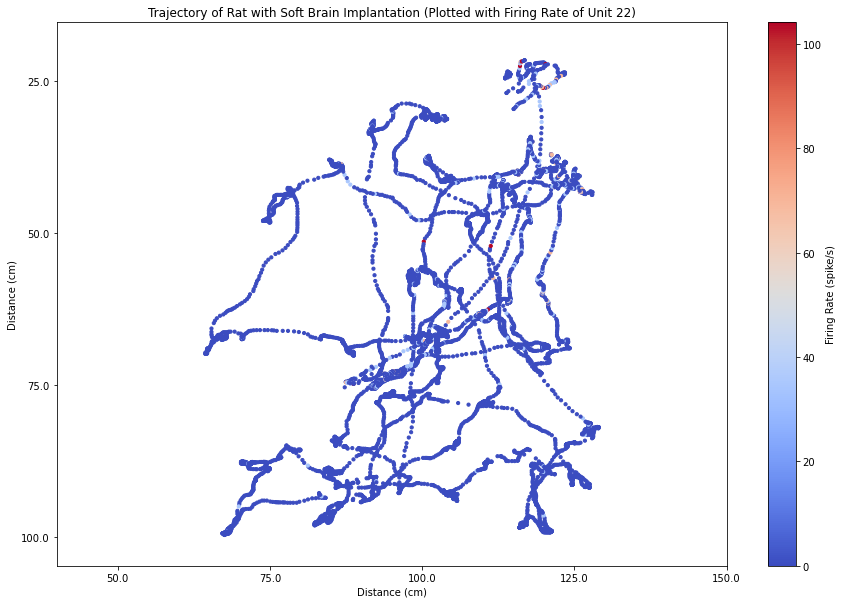

In [11]:
count_per_bin = np.load('count_per_bin.npy') / (1 / fps)
num_units = count_per_bin.shape[0]

%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 10))
unit_id = 22

i = 1 # corresponding to body center
x_i = i*2
y_i = x_i + 1

ax.axis('equal')
plt.scatter(body_part_arr[:round(sec_to_compare * fps), x_i],\
                body_part_arr[:round(sec_to_compare * fps), y_i], marker = 'o', s= 10, label=body_parts[i], \
               cmap=cm.coolwarm, c=count_per_bin[unit_id,:])
plt.colorbar(label="Firing Rate (spike/s)", orientation="vertical")

    
# plt.vlines(x=200, ymin=200, ymax=1400, colors='k', ls=':', lw=2)
# plt.vlines(x=1400, ymin=200, ymax=1400, colors='k', ls=':', lw=2) 
# plt.hlines(y=200, xmin=200, xmax=1400, colors='k', ls=':', lw=2)
# plt.hlines(y=1400, xmin=200, xmax=1400, colors='k', ls=':', lw=2, label='approximate_field')

# plt.xlim([0, 1648])
# plt.ylim([0, 1648])

plt.xticks(np.arange(0, width, 200), np.round(np.arange(0, width, 200)/pixels_per_m*100,1))
plt.yticks(np.arange(0, height, 200), np.round(np.arange(0, height, 200)/pixels_per_m*100,1))
plt.xlim([40*pixels_per_m/100, 150*pixels_per_m/100])
plt.ylim([0*pixels_per_m/100, 120*pixels_per_m/100])
ax.invert_yaxis()
plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')
plt.title('Trajectory of Rat with '+ rat_type +f' Implantation (Plotted with Firing Rate of Unit {unit_id})')

# plt.legend()
plt.show()

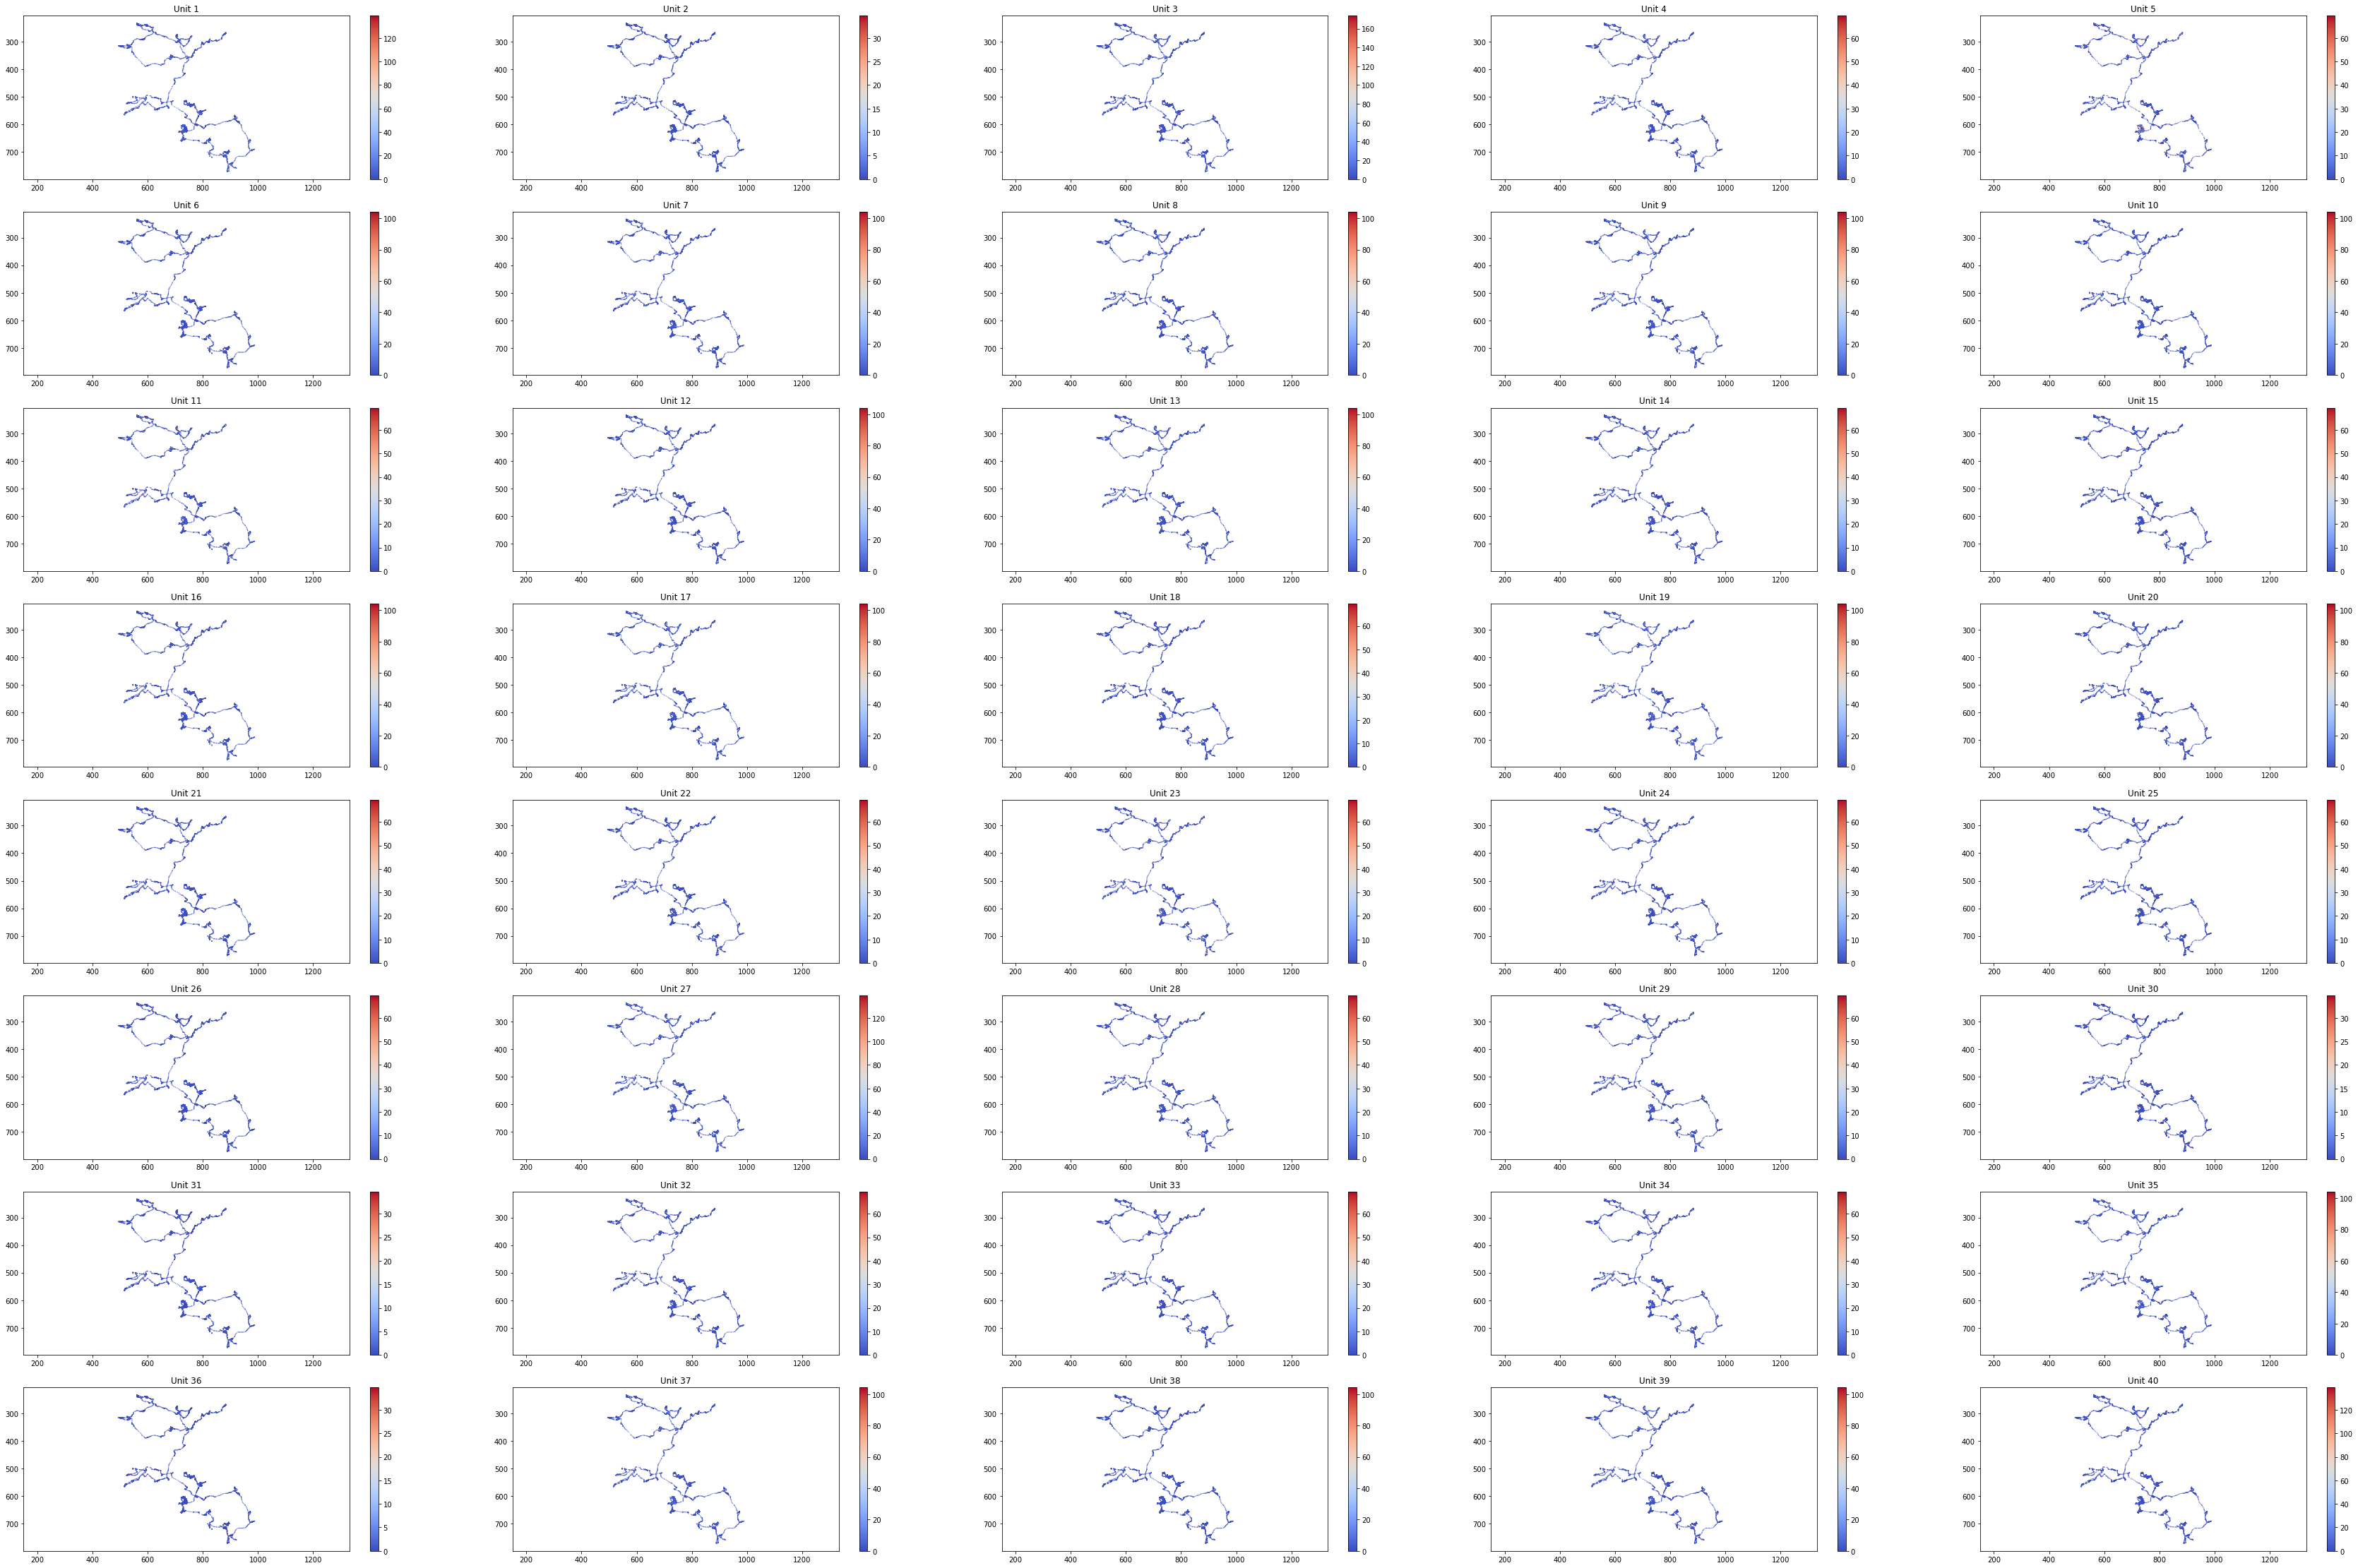

In [69]:
%matplotlib inline
fig, ax = plt.subplots(8,5,figsize=(60, 40))

i = 1 # corresponding to body center
x_i = i*2
y_i = x_i + 1
for j in range(num_units):
    row = int(np.floor(j / 5))
    col = j % 5
    ax[row, col].axis('equal')
    sub = ax[row, col].scatter(body_part_arr[:round(sec_to_compare * fps), x_i],\
                body_part_arr[:round(sec_to_compare * fps), y_i], marker = 'o', s= 0.1, label=body_parts[i], \
               cmap=cm.coolwarm, c=count_per_bin[j,:])
#     plt.colorbar(label="Firing Rate (spike/s)", orientation="vertical", ax=ax[row, col])
    fig.colorbar(sub, ax=ax[row, col])
    ax[row, col].set_title(f'Unit {j+1}')
    ax[row, col].invert_yaxis()
    
# plt.vlines(x=200, ymin=200, ymax=1400, colors='k', ls=':', lw=2)
# plt.vlines(x=1400, ymin=200, ymax=1400, colors='k', ls=':', lw=2) 
# plt.hlines(y=200, xmin=200, xmax=1400, colors='k', ls=':', lw=2)
# plt.hlines(y=1400, xmin=200, xmax=1400, colors='k', ls=':', lw=2, label='approximate_field')

# plt.xlim([0, 1648])
# plt.ylim([0, 1648])

# plt.xticks(np.arange(0, width, 200), np.round(np.arange(0, width, 200)/pixels_per_m*100,1))
# plt.yticks(np.arange(0, height, 200), np.round(np.arange(0, height, 200)/pixels_per_m*100,1))
# plt.xlim([40*pixels_per_m/100, 150*pixels_per_m/100])
# plt.ylim([15*pixels_per_m/100, 120*pixels_per_m/100])

# plt.xlabel('Distance (cm)')
# plt.ylabel('Distance (cm)')
# plt.title('Trajectory of Rat with '+ rat_type +' Implantation (Plotted with Firing Rate)')

# plt.legend()
plt.show()

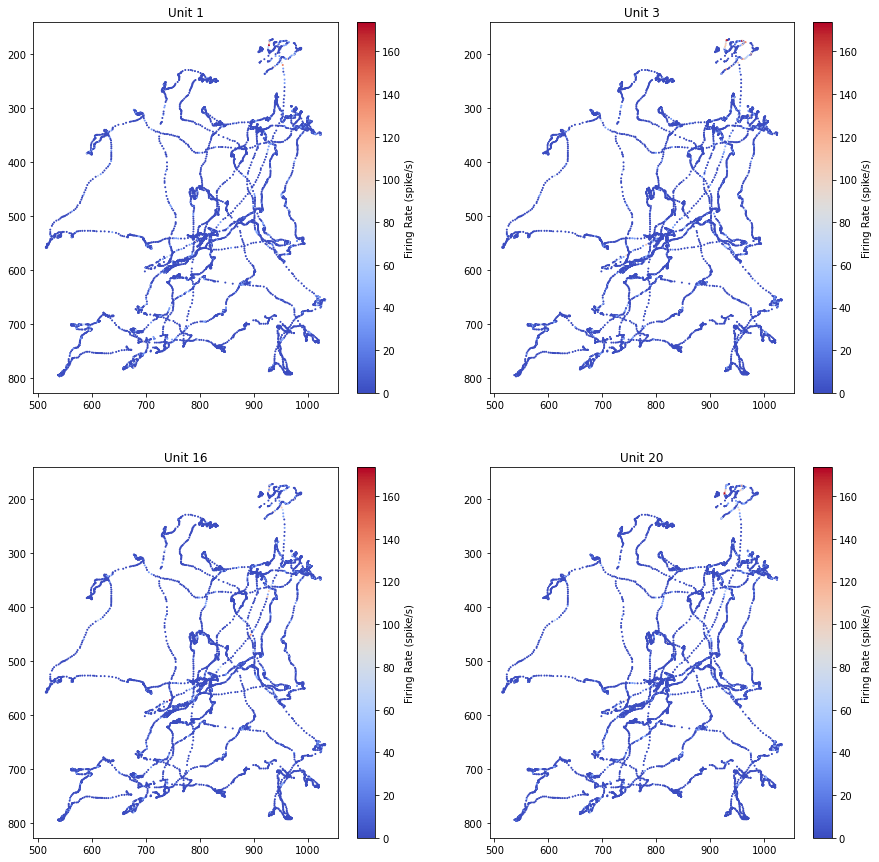

In [18]:
%matplotlib inline
fig, ax = plt.subplots(2,2,figsize=(15, 15))

i = 1 # corresponding to body center
x_i = i*2
y_i = x_i + 1
for num, j in enumerate([0,2,15,19]) :
    row = int(np.floor(num / 2))
    col = num % 2
    ax[row, col].axis('equal')
    sub = ax[row, col].scatter(body_part_arr[:round(sec_to_compare * fps), x_i],\
                body_part_arr[:round(sec_to_compare * fps), y_i], marker = 'o', s= 1, label=body_parts[i], \
               cmap=cm.coolwarm, c=count_per_bin[j,:])
    # plt.colorbar(label="Firing Rate (spike/s)", orientation="vertical", ax=ax[row, col])
    fig.colorbar(sub, ax=ax[row, col], label="Firing Rate (spike/s)", orientation="vertical",)
    ax[row, col].set_title(f'Unit {j+1}')
    ax[row, col].invert_yaxis()
    
# plt.vlines(x=200, ymin=200, ymax=1400, colors='k', ls=':', lw=2)
# plt.vlines(x=1400, ymin=200, ymax=1400, colors='k', ls=':', lw=2) 
# plt.hlines(y=200, xmin=200, xmax=1400, colors='k', ls=':', lw=2)
# plt.hlines(y=1400, xmin=200, xmax=1400, colors='k', ls=':', lw=2, label='approximate_field')

# plt.xlim([0, 1648])
# plt.ylim([0, 1648])

# plt.xticks(np.arange(0, width, 200), np.round(np.arange(0, width, 200)/pixels_per_m*100,1))
# plt.yticks(np.arange(0, height, 200), np.round(np.arange(0, height, 200)/pixels_per_m*100,1))
# plt.xlim([40*pixels_per_m/100, 150*pixels_per_m/100])
# plt.ylim([15*pixels_per_m/100, 120*pixels_per_m/100])

# plt.xlabel('Distance (cm)')
# plt.ylabel('Distance (cm)')
# plt.title('Trajectory of Rat with '+ rat_type +' Implantation (Plotted with Firing Rate)')

# plt.legend()
plt.show()

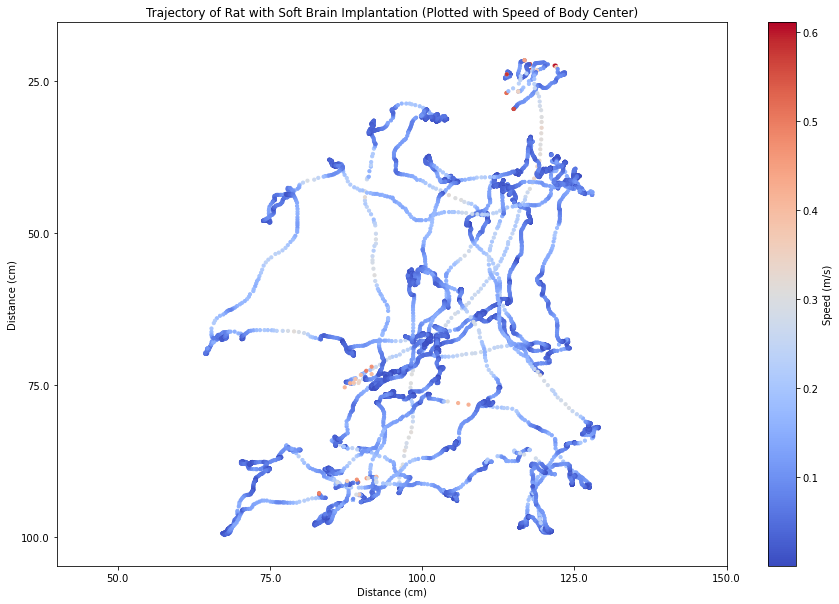

In [19]:


%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis('equal')
i = 1 # corresponding to body center
x_i = i*2
y_i = x_i + 1
plt.scatter(body_part_arr[:round(sec_to_compare * fps), x_i],\
            body_part_arr[:round(sec_to_compare * fps), y_i], marker = 'o', s=10, label=body_parts[i], \
           cmap=cm.coolwarm, c=speed_filtered[:round(sec_to_compare * fps)])
plt.colorbar(label="Speed (m/s)", orientation="vertical")
    
# plt.vlines(x=200, ymin=200, ymax=1400, colors='k', ls=':', lw=2)
# plt.vlines(x=1400, ymin=200, ymax=1400, colors='k', ls=':', lw=2) 
# plt.hlines(y=200, xmin=200, xmax=1400, colors='k', ls=':', lw=2)
# plt.hlines(y=1400, xmin=200, xmax=1400, colors='k', ls=':', lw=2, label='approximate_field')

# plt.xlim([0, 1648])
# plt.ylim([0, 1648])

plt.xticks(np.arange(0, width, 200), np.round(np.arange(0, width, 200)/pixels_per_m*100,1))
plt.yticks(np.arange(0, height, 200), np.round(np.arange(0, height, 200)/pixels_per_m*100,1))
plt.xlim([40*pixels_per_m/100, 150*pixels_per_m/100])
plt.ylim([0*pixels_per_m/100, 120*pixels_per_m/100])

plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')
plt.title('Trajectory of Rat with '+ rat_type +' Implantation (Plotted with Speed of Body Center)')
ax.invert_yaxis()
# plt.legend()
plt.show()

# Save activity and video parameters 

In [52]:
station = np.sum((speed_filtered[:round(sec_to_compare * fps)] < cutoff_v)*1)
moving = len(speed_filtered[:round(sec_to_compare * fps)]) - station
moving
df_export = pd.DataFrame(np.array([station, moving, fps, total_distance[-1], top_speed]).reshape(1, -1), \
                         index=[rat_type], columns = ['station', 'moving', 'fps', 'total_distance', 'top_speed'] )
df_export.to_csv(project_name[1:] + '_results.csv', header=True, index=True)

# Save all the frames

In [ ]:
if not os.path.isdir('frames'):
    os.mkdir('frames')
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        cv2.imwrite('frames/' + str(i) + '.jpg', frame)
        i += 1


In [14]:
fps

34.722

# Plot animation

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(8,10))
# plt.title('Trajectory of Rat with Soft Implantation')
# plt.xticks(range(width), np.arange(width)/pixels_per_m*100)

def animate(i):
    ax[0].clear()
    ax[1].clear()
    im = plt.imread('frames/' + str(i)+'.jpg')
    ax[0].imshow(im)
    

    if i < 150:
        ax[1].plot(speed[:i+1])
        for j, body_part in enumerate(body_parts):
            x_i = j*2
            y_i = x_i + 1
            ax[0].plot(body_part_arr[:i+1, x_i], body_part_arr[:i+1, y_i], lw=0.5, label=body_part)
    else:
        ax[1].plot(speed[i-149:i+1])
        for j, body_part in enumerate(body_parts):
            x_i = j*2
            y_i = x_i + 1
            ax[0].plot(body_part_arr[i-149:i+1, x_i], body_part_arr[i-149:i+1, y_i], lw=0.5, label=body_part)

    ax[0].legend(bbox_to_anchor=(1.31,1))
    ax[0].set_title('Trajectory of Rat with '+ rat_type +' Implantation')
    ax[0].set_xticks(np.arange(0, width, 200), np.round(np.arange(0, width, 200)/pixels_per_m*100,1))
    ax[0].set_yticks(np.arange(0, height, 200), np.round(np.arange(0, height, 200)/pixels_per_m*100,1))
    ax[0].set_xlabel('Distance (cm)')
    ax[0].set_ylabel('Distacne (cm)')

    ax[1].set_title('Body Center Real Time Speed of Rat with '+ rat_type +' Implantation')
    ax[1].set_xticks(np.arange(0, 151, 25), np.round(np.arange(0, 151, 25) / fps, 1))
    ax[1].set_xlabel('Time (s) ')
    ax[1].set_ylabel('Speed (m/s)')
    ax[1].set_ylim([0, 1.6])
    
    if speed[i] < cutoff_v:
        ax[1].annotate('Stationary', (0.8,0.9), textcoords='axes fraction', size=10)
    else:
        ax[1].annotate('Moving', (0.8, 0.9), textcoords='axes fraction', size=10)
        
anim = animation.FuncAnimation(fig, animate, frames=body_part_arr.shape[0], interval=1000/fps, repeat=False)

# Save animation

In [ ]:
warnings.filterwarnings("ignore")

f = 'tracker.avi'
writevideo = animation.FFMpegWriter(fps=fps)
anim.save(f, writer=writevideo)
